In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import pickle
from sklearn import metrics

from keras import regularizers
from keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Load the VGGish model from TensorFlow Hub.
vggish_model_url = 'https://tfhub.dev/google/vggish/1'
model = hub.load(vggish_model_url)

# Sample audio waveform (replace this with your actual audio data).
# For example, you can load audio data using librosa or any other library.
waveform = np.random.randn(1 * 15700).astype(np.float32)

# Run the model to generate embeddings.
embeddings = model(waveform)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (1, 128)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Getting Embeddings


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Amen_Remastered/Outputs/Complete_df.txt')

#processed_tensors = []
k = 3210+412
for j,i in enumerate(df['filename'][k:]):
  if j<5:
    print(i)
  y,sr = librosa.load(i)
  y_16k = librosa.resample(y, orig_sr=sr, target_sr=16000)
  processed_data = model(y_16k)
  processed_tensors.append(processed_data)

combined_tensor = tf.stack(processed_tensors, axis=0)

In [ ]:
with open('VGG_embeddings.pickle', 'wb') as handle:
    pickle.dump(combined_tensor, handle)

# Transfer Learning


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Amen_Remastered/Outputs/Complete_df.txt')

In [ ]:
with open('/content/gdrive/MyDrive/Amen_Remastered/Outputs/VGG_embeddings.pickle', 'rb') as handle:
    VGG_embeddings = pickle.load(handle)

In [ ]:
reshaped_embeddings = tf.reshape(VGG_embeddings, (3626, -1))

In [ ]:
def get_partitions(x):
  validation_indices = df[df['Set'] == x].index
  validation_indices_tensor = tf.constant(validation_indices)
  validation_embeddings = tf.gather(reshaped_embeddings, validation_indices_tensor)
  return validation_embeddings

training_set = get_partitions('train')
validation_set = get_partitions('validation')
test_set = get_partitions('test')

train_meta = df[df['Set'] == 'train']
validation_meta = df[df['Set'] == 'validation']
test_meta = df[df['Set'] == 'test']


In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(training_set , train_meta['Label'])

In [ ]:
tf.random.set_seed(64)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1280,)),  # Assuming each sample has shape (128,)
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer = regularizers.L1L2(l1=1e-3, l2=1e-4)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.summary()

In [ ]:
history = model.fit(X_train_resampled, y_train_resampled,
          validation_data= (validation_set,validation_meta['Label']),
          #validation_split = 0.2,
          shuffle=True,
          epochs=80, batch_size=32)

Epoch 1/80
115/115 [==============================] - 2s 10ms/step - loss: 6.0021 - accuracy: 0.5925 - val_loss: 5.9709 - val_accuracy: 0.5549
Epoch 2/80
115/115 [==============================] - 1s 10ms/step - loss: 5.8308 - accuracy: 0.7432 - val_loss: 5.8045 - val_accuracy: 0.6817
Epoch 3/80
115/115 [==============================] - 1s 10ms/step - loss: 5.6827 - accuracy: 0.7774 - val_loss: 5.6663 - val_accuracy: 0.7127
Epoch 4/80
115/115 [==============================] - 1s 8ms/step - loss: 5.5512 - accuracy: 0.7949 - val_loss: 5.5264 - val_accuracy: 0.7549
Epoch 5/80
115/115 [==============================] - 1s 6ms/step - loss: 5.4295 - accuracy: 0.8020 - val_loss: 5.4189 - val_accuracy: 0.7606
Epoch 6/80
115/115 [==============================] - 1s 6ms/step - loss: 5.3140 - accuracy: 0.8118 - val_loss: 5.2934 - val_accuracy: 0.7915
Epoch 7/80
115/115 [==============================] - 1s 6ms/step - loss: 5.2027 - accuracy: 0.8167 - val_loss: 5.1849 - val_accuracy: 0.7915
Epo

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy',color = '#54B8DC')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color = 'purple')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('train_val.png', transparent=True)
plt.show()

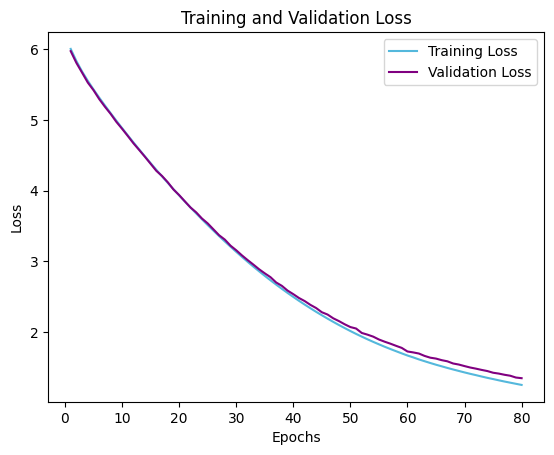

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss', color='#54B8DC')
plt.plot(epochs, val_loss, label='Validation Loss', color='purple')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_val_loss.png', transparent=True)
plt.show()

In [ ]:
result = model(test_set, test_meta['Label']).numpy()
test_meta['Predicted'] = np.rint(result)

test_meta[['Label','Predicted']]

def get_metrics(df):

  acc = metrics.accuracy_score(df['Label'],df['Predicted'])
  rec = metrics.recall_score(df['Label'],df['Predicted'])
  prec = metrics.precision_score(df['Label'],df['Predicted'])

  return np.array([acc,rec,prec])



<ipython-input-128-a3da4eecee85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['Predicted'] = np.rint(result)


In [ ]:
get_metrics(test_meta)

array([0.85123967, 0.84313725, 0.69354839])

In [ ]:
genres = ['Electronic / Dance','Hip-Hop / Rap / R&B',
          'Rock / Pop','Soundtrack / Library']
size = len(genres)
genre_metrics = pd.DataFrame(columns = ['Acc','Recall','Prec'])

for j,i in enumerate(genres):

  genre_df = test_meta[test_meta['Genre'] == i]
  genre_metrics.loc[i] = get_metrics(genre_df)

sns.heatmap(genre_metrics,cmap="crest",vmin=0, vmax=1,annot = True)
plt.tight_layout()
plt.savefig('Genre_analysis',transparent = True)
plt.show()

In [ ]:
a

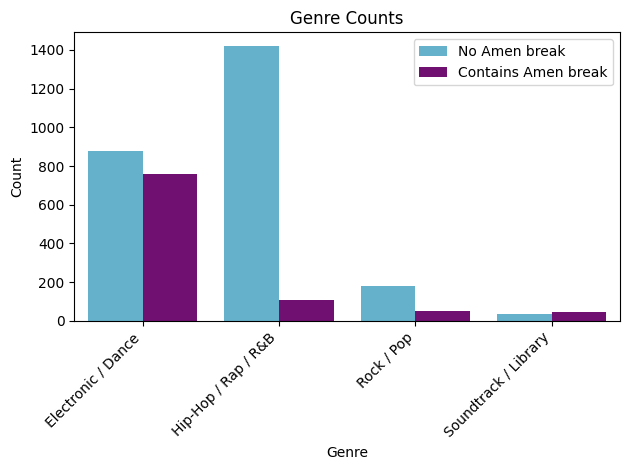

In [ ]:
a = df.groupby(['Genre','Label'])[['Set']].count()
b = a.loc[['Electronic / Dance','Hip-Hop / Rap / R&B','Rock / Pop','Soundtrack / Library']]

sns.barplot(data=b,x = 'Genre',y = 'Set', hue = 'Label',palette=['#54B8DC', 'purple'])
plt.savefig('Genre_counts',transparent = True)
# Tilt the xticks (rotate them)
plt.xticks(rotation=45,ha='right')
plt.ylabel('Count')
plt.title('Genre Counts')
#plt.legend(labels=['Custom Label 1', 'Custom Label 2'])
handles, labels = plt.gca().get_legend_handles_labels()

# Set custom legend labels and maintain colors
custom_labels = ['No Amen break', 'Contains Amen break']
plt.legend(handles, custom_labels)
# Adjust layout to accommodate xticks properly
plt.tight_layout()
plt.savefig('Genre_barplot.png', transparent=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

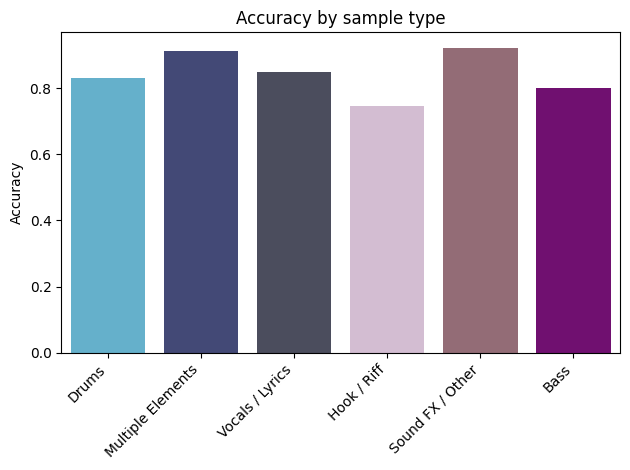

In [ ]:
sample_types = test_meta['Sample_type'].unique()

size = len(sample_types)
sample_metrics = pd.DataFrame(columns = ['Acc'])

for j,i in enumerate(sample_types):

  genre_df = test_meta[test_meta['Sample_type'] == i]
  sample_metrics.loc[i] = get_metrics(genre_df)[0]

sns.barplot(sample_metrics.transpose(),palette=['#54B8DC','#3A427E','#484B60','#D7B9D5','#996673','purple'])
plt.xticks(rotation=45,ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy by sample type')
plt.tight_layout()
plt.savefig('Sample_type_barplot.png', transparent=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


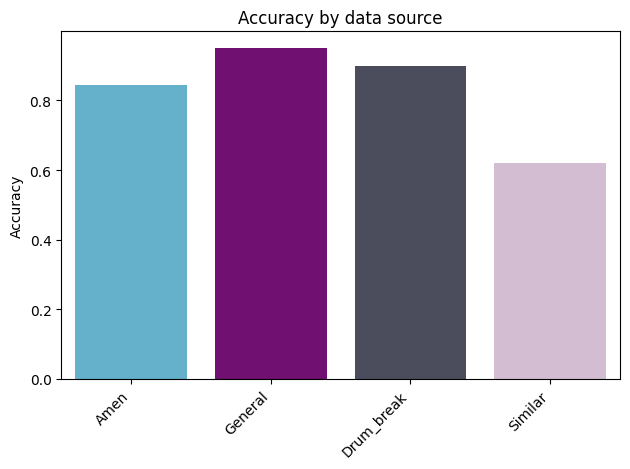

In [ ]:
data_sources = test_meta['Data_source'].unique()

size = len(data_sources)
source_metrics = pd.DataFrame(columns = ['Acc'])

for j,i in enumerate(data_sources):

  genre_df = test_meta[test_meta['Data_source'] == i]
  source_metrics.loc[i] = get_metrics(genre_df)[0]

sns.barplot(source_metrics.transpose(),palette=['#54B8DC', 'purple','#484B60','#D7B9D5'])
plt.xticks(rotation=45,ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy by data source')
#plt.legend(labels=['Custom Label 1', 'Custom Label 2'])
#handles, labels = plt.gca().get_legend_handles_labels()

# Set custom legend labels and maintain colors
#custom_labels = ['No Amen break', 'Contains Amen break']
#plt.legend(handles, custom_labels)
# Adjust layout to accommodate xticks properly
plt.tight_layout()
plt.savefig('Sample_type_barplot.png', transparent=True)
plt.show()

In [ ]:
test_meta

In [ ]:
tm = test_meta[test_meta['Label'] != test_meta['Predicted']]
tm[tm['Data_source'] == 'Similar']['Page'].tail(50)

3087    https://www.whosampled.com/sample/201383/Dr.-B...
3088    https://www.whosampled.com/sample/561261/Cirru...
3091    https://www.whosampled.com/sample/222690/Parad...
3103    https://www.whosampled.com/sample/761099/Masay...
3112    https://www.whosampled.com/sample/733567/Smile...
3117    https://www.whosampled.com/sample/12444/Kid606...
3119    https://www.whosampled.com/sample/589824/Kohta...
3121    https://www.whosampled.com/sample/267512/AFX-E...
3124    https://www.whosampled.com/sample/54530/Hideki...
3127    https://www.whosampled.com/sample/78973/Sonz-o...
3128    https://www.whosampled.com/sample/102217/Broth...
3140    https://www.whosampled.com/sample/494430/Hoso-...
3146    https://www.whosampled.com/sample/60919/Rebel-...
3148    https://www.whosampled.com/sample/97798/Utah-J...
3152    https://www.whosampled.com/sample/319011/Naofu...
3159    https://www.whosampled.com/sample/121264/Marik...
3160    https://www.whosampled.com/sample/19855/Luther...
3161    https: